# Project 1 - Data Engineering
## 2 Data Exploration and Analysis
This notebook is for the implementation of task "2 Data Exploration and Analysis", as listed in the **Project Instructions**.

<div class="alert alert-success">
<b>Overview:</b><br>
Data Exploration and Analysis consists of the following parts worth 70 points:
<ul>
    <li><b>E1 - Obtain and Scrub</b> (15 points)</li>
    <li><b>E2 - Exploratory data analysis (EDA) </b>(20 points)</li>
    <li><b>E3 - Formulate hypotheses </b>(25 points)</li>
    <li><b>Follow the guidelines for Data Exploration and Analysis below </b>(10 points)</li>
</ul></div>

<div class="alert alert-success">
<b>Guidelines for Data Exploration and Analysis:</b><br>
    <ol>
        <li>Use a single Jupyer notebook for your project.</li>
        <li>Use only Python-code for your project.</li>
        <li>The use of automatic and semi-automatic data analyis tools is not allowed (e. g., PandasGUI, D-Tale, Mito, etc.). Only use packages we used in the coded lectures.</li>
        <li>Export your environment for submission as 'prj01-environment.txt'.</li>
        <li>Upload your resulting work as a zip file containing only a single jupyter notebook and required files to run the notebook. All cell outputs and <b>figures must display in jupyter lab</b>. (Test this, in particular when you use another environment like VS Code.)</li>
        <li>All code cells in your notebook must be runnable without errors or warnings (e. g., deprecated functions). Each error/warning subtracts -2 points (up to the full 10 points for following the  guidelines).</li>
        <li>Use only relative paths in your project.</li>
        <li>Avoid (excessive) code duplication.</li>
        <li>Avoid loops iterating over pandas objects (Series, DataFrames). Explicitly justify each exception via a comment. </li>
        <li>All coded steps in your analysis must be commented.</li>
        <li>Keep your code as well as outputs short, precise and readable. Each long or unnecessary output subtracts -2 points (up to the full 10 points for following the project guidelines).</li>
    </ol>
    <b>Late submissions are not accepted and earn you 0 points on the python project. </b>
</div>

Explicitly list which notebook toolset was used (jupyter lab/jupyter notebook/VS Code/etc.) 

**here**: MY_TOOL, MY_BROWSER

Explicitly and clearly state the chosen dataset number and title:
### Bevölkerung ODÖ Hunde 
## Hunde pro Bezirk Wien, Hunderassen Wien, Hundebestand seit 2002 - Bezirke Wien


## E1 - Obtain and Scrub

### Obtain
Download the dataset and understand both: 
- format: wide vs. long, separaters, decimal points, encoding, etc., and 
- content: what variables are in the columns, what is their meaning?
To this end, identify and download metadata such as headers, category listings, explanatory reports, etc.
### Scrub
The aim of scrub is to create a clean version of the data for further analysis. 
- Load the dataset and take care of dtypes (dates, numbers, categories, etc.). Justify why you don't load/use specific columns.
- Check for footnotes or any other notifications on special cell content, such as time series breaks. Follow up that information, and document your decision how to deal with it. Remember: A homework contained such info in the cell "76.1 b". The metadata defines what that "b" stands for.
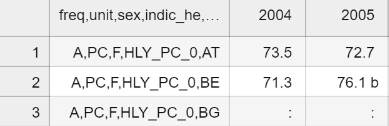
- Choose an appropriate (Multi-)Index.
- Identify:
    1. missing values and get row and column overviews. Use graphical and/or numeric approaches. Once identified, handle missing values according to column type, time series property and data set size.
    2. duplicates (justify the used column subset). Remove duplicates - if any - and inspect what you removed.
- Transform to shape (tidy vs. wide) best suited for further analysis.
- Export the clean data to a file for inspection with an external data browser (e.g., MS Excel).
- Provide an overview of the clean dataset:
    1. show the dtypes
    2. quantitative column descriptions: 
        1. categorical columns: number of unique values, counts 
        2. numeric columns: range and median

In [1]:
# Importing necessary packages:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colormaps
import geopandas as gpd

In [13]:
# E1: Obtain

dogs_2002 = pd.read_csv("vie-bez-biz-spo-dog-2002f.csv", sep=';')
dog_types = pd.read_csv("hunde-wien.csv", sep=';', encoding='utf-8', encoding_errors='ignore')
dogs_2 = pd.read_csv("hunde-vie.csv", encoding='utf-8', encoding_errors='ignore', sep=';')





In [9]:
dogs_2002.head()

,Anzahl der Hunde (absolut und pro 1.000 EinwohnerInnen) seit 2002 - Bezirke Wien | Number of dogs (absolute and per 1,000 inhabitants) since 2002 - districts of Vienna;;;;;;;;;;;;;;;;
0,NUTS;DISTRICT_CODE;SUB_DISTRICT_CODE;REF_YEAR;...,NaN
1,AT13;90000;90000;2002;20020101; 46.933 ; 29,87 ;;;;;;;;;;
2,AT13;90100;90100;2002;20020101; 542 ; 30,74 ;;;;;;;;;;
3,AT13;90200;90200;2002;20020101; 2.251 ; 25,29 ;;;;;;;;;;
4,AT13;90300;90300;2002;20020101; 1.904 ; 23,16 ;;;;;;;;;;


In [10]:
dog_types.head()

,Hunderassen in Wien | Breed of Dogs in Vienna;;;;;;;;
0,NUTS1;NUTS2;NUTS3;DISTRICT_CODE;SUB_DISTRICT_C...
1,AT1;AT13;AT113;90100;.;1010;Afghanischer Windh...
2,AT1;AT13;AT113;90100;.;1010;Akita / Belgischer...
3,AT1;AT13;AT113;90100;.;1010;Alaskan Malamute;1...
4,AT1;AT13;AT113;90100;.;1010;American Cocker Sp...


In [11]:
dogs_2.head()

,Hunderassen in Wien | Breed of Dogs in Vienna;;;;;;;;
0,NUTS1;NUTS2;NUTS3;DISTRICT_CODE;SUB_DISTRICT_C...
1,AT1;AT13;AT113;90100;.;1010;Afghanischer Windh...
2,AT1;AT13;AT113;90100;.;1010;Amerikanischer Coc...
3,AT1;AT13;AT113;90100;.;1010;Amerikanischer Sta...
4,AT1;AT13;AT113;90100;.;1010;Australian Shepher...


## E2 - Exploratory data analysis (EDA)
Use the clean dataset and understand and explore the relationships in the data (numerical, visual, statistical). This includes at least but is not limited to:
- A comprehensive textual description of meaning for relevant fields in the dataset
- Statistical/numerical descriptions and visualization techniques we learned in the course inluding correlations, distributions and groupings of variing degrees.
- Checks for data quality, e. g., completeness, plausibility, outliers
- Handling any identified problems with the data
- If necessary, use additional data wrangling in line with your EDA and only keep what's necessary for the following steps of your analysis with appropriate data granularity and form ("tidy data")

Don't:
- test/prove hypotheses here. EDA should only motivate hypotheses. 

Advanced/bonus:
- Depending on your hypothesis you may want to join external data (e.g., merge external highest education level to existing vaccination data) for additional insights.

Explain all steps taken and your thinking why you deem them necessary.

In [2]:
# E2:








## E3 - Formulate hypotheses

*Note: Read this section entirely and understand it - every group member.*

A hypothesis is an idea or explanation for something that is based on known facts but has not yet been proved. A hypothesis is a compact, concise statement, such as: "Individuals with higher income have (on average) more offspring.", that will be answered based on facts (the data). https://gradcoach.com/what-is-a-research-hypothesis-or-scientific-hypothesis/

Formulate *N* non-trivial hypotheses, 1 per group member, and regard the following criteria: 
- State the hypothesis explicitly in concise language. 
- The hypothesis must be **motivated** by either **EDA results** or **literature** (citation in the report needed).
- The hypothesis must refer to **endpoints** that are **testable**. Specifically, the endpoint must be derived from the data.
- Think of real-life use cases/consequences of your results (textual description). 
- For each hypothesis explain all executed steps. 
- In case of extreme or implausible results check the validity of your data.
- For each hypothesis export the artifacts (figures, tables, etc.) required for the report.
- If you decide to use a statistical test, use it properly. In particular, check the validity and comparability of the samples.

Do not:
- State nebulous, vague hypotheses. These don't contain endpoints and are unclear to test (i.e., answer).
- Use post-hoc hypotheses. Portraying an empirically inspired **post hoc hypothesis as a priori** violates the **falsification principle** crucial for hypothesis-driven (that is, confirmatory) empirical research. Falsification is severe scientific fraud.
- State trivial hypotheses (e.g., hypthesis 2: "Not Hypothesis 1").
- Answer based on "common knowledge".
- Try to **produce positively tested hypotheses**. If a well motivated hypothesis is negative, this is an important finding (see Simpson's Paradox). The value of a tested hypothesis lies in the information or learning it provides.

Example: The homework with Simpson's Paradox. The pooled overall comparison between the genders would be the EDA motivating the hypothesis: "At UC Berkeley the by-department admissions rate for females is lower than for males." It should be tested using samples of department admission rates for the 2 **groups** male and female. No steps of the test should be done in EDA (or a priory to stating the hypothesis). The groups should be compared graphically, e.g., via a stripplot overlayed with a boxplot. The figure should be labelled properly and exported for the report. A (paired) t-test **may** be used (it's optional) to test this hypothesis statistically. For different data (e.g., time series) different approaches may be required. You don't have to use statistical tests, in particular if you don't know what they are doing.


### E3-H1: "xxx"
Author: Group member 1


### E3-H2: "xxx"
Author: Group member 2



### E3-H3: "xxx"
Author: Group member 3


### E3-H4: "xxx"
Author: Group member 4


### E3-H5: "xxx"
Author: Group member 5
